In [4]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import time
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.size'] = 10
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Times New Roman']

from canon.pattern.model import GMModel, KMeansModel, BGMModel, MeanShiftModel
from canon.seq.seqreader import SeqReader
from canon.pattern.labeler import SeqLabeler

np.random.seed(4)

def read_seq(seq, key="orsnr___"):
    seqfile = os.path.join("seq", seq+".SEQ")
    reader = SeqReader(seqfile)    
    Z = reader.get_Zmap(key)[0]
    return Z[::-1, :]

def fill_features(features, img_shape):
    num_points = np.prod(img_shape)
    if len(features) != num_points:
        print("Filling %d features to %d data points" % (len(features), num_points))
        features2 = np.zeros((np.prod(img_shape), features.shape[1] - 1))
        features2[features[:, 0].astype('int') - 1] = features[:, 1:]
        return features2
    else:
        return features[:, 1:]
    
def xy_to_idx(x, y, img_shape):
    return y * img_shape[1] + x

def idx_to_xy(idx, img_shape, flip_vertical=True):
    x = int(idx / img_shape[1])
    y = idx % img_shape[1]
    if flip_vertical:
        x = img_shape[0] - x - 1
    return y, x

In [18]:
feature_file = "BTO_25C_wb3_60_100"
img_shape = (60, 100)
with h5py.File(os.path.join("features", feature_file +'.hdf5'), 'r') as h5f:
    data = np.array(h5f.get("ae_conv_4_256_best"))
    print(data.shape)
    features = fill_features(data, img_shape)

(6000, 257)


Silhouette Score = 0.014290032649533501, Calinski-Harabaz Score = 133.51279203192195


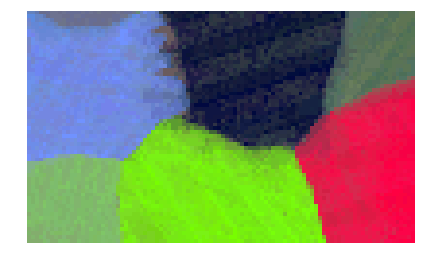

In [19]:
model = KMeansModel()
pca = PCA(n_components=12)
scaler = StandardScaler()
model.train(features, n_clusters=256, preprocessors=[pca])

silhouette = model.compute_silhouette_score(features)
calinski = model.compute_calinski_harabaz_score(features)
print("Silhouette Score = {}, Calinski-Harabaz Score = {}".format(silhouette, calinski))

scores = np.array(model.score(features))
Z = model.color_by_pca(scores.reshape(img_shape), scaling='centroids')

fig, ax = plt.subplots(ncols=1, nrows=1)
ax.imshow(Z[::-1, :, :], aspect=1)
ax.axis('off')
plt.tight_layout()
# fig.savefig("img/Z.pdf", bbox_inches='tight', figsize=(5, 4), dpi=300)

(6000, 3)
(60, 100, 3)


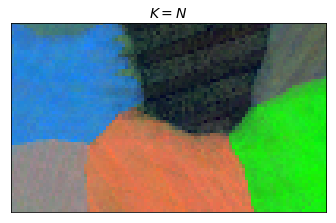

In [20]:
pca = PCA(n_components=3)
X = pca.fit_transform(features)
pca_range = [X.min(axis=0), X.max(axis=0)]
X = (X - pca_range[0]) / (pca_range[1] - pca_range[0])
print(X.shape)
Z = np.zeros((img_shape[0], img_shape[1], 3))
Z[:, :, 0] = X[:, 0].reshape(img_shape)
Z[:, :, 1] = X[:, 1].reshape(img_shape)
Z[:, :, 2] = X[:, 2].reshape(img_shape)
print(Z.shape)

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 4))
ax.imshow(Z[::-1, :, :], aspect=1)
# ax.axis('off')
plt.tight_layout()
ax.set_title(r'$K=N$', fontsize=14)
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
# fig.savefig("img/BTO_KM_PCA_N.pdf", bbox_inches='tight', dpi=300)

Modeling for 6 clusters
Silhouette Score = 0.47592741571952485, Calinski-Harabaz Score = 2758.678155135427
Modeling for 12 clusters
Silhouette Score = 0.2646252125875127, Calinski-Harabaz Score = 1732.246630239072
Modeling for 64 clusters
Silhouette Score = 0.0990079408660438, Calinski-Harabaz Score = 476.6044639416999
Modeling for 256 clusters
Silhouette Score = 0.07822066776073137, Calinski-Harabaz Score = 161.57434739857044


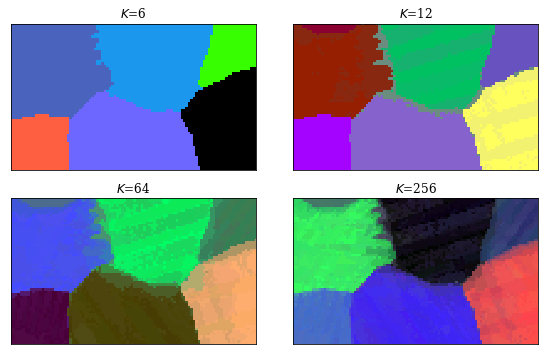

In [22]:
ncols=2
nrows=2 
fig, ax = plt.subplots(nrows, ncols, figsize=(4*ncols, 2.5*nrows))
Ks = [6, 12, 64, 256]
#Ks = [6, 12, 12, 12]

for i in range(nrows):
    for j in range(ncols):
        
        K = Ks[i * ncols + j]
        print("Modeling for {} clusters".format(K))
        
        model = KMeansModel()
        pca = PCA(n_components=32)
        scaler = StandardScaler()
        model.train(features, n_clusters=K, preprocessors=[])

        silhouette = model.compute_silhouette_score(features)
        calinski = model.compute_calinski_harabaz_score(features)
        print("Silhouette Score = {}, Calinski-Harabaz Score = {}".format(silhouette, calinski))

        scores = np.array(model.score(features))
        Z = model.color_by_pca(scores.reshape(img_shape), scaling='centroids')
        
        if ncols == 1 and nrows == 1:
            ax0 = ax
        elif ncols == 1 or nrows == 1:
            ax0 = ax[i * ncols + j]
        else:
            ax0 = ax[i, j]
        img = ax0.imshow(Z[:, :], cmap='jet', aspect=1)
        # plt.colorbar(img, ax=ax0, fraction=0.03)
        ax0.set_xlim([0, img_shape[1] - 1])
        ax0.set_ylim([0, img_shape[0] - 1])        
        ax0.set_title(r'$K$={}'.format(K), fontsize=12)
        ax0.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax0.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
        
plt.tight_layout()

In [23]:
fig.savefig("img/BTO_KM_PCA.pdf", dpi=300)

Modeling for 6 clusters
Silhouette Score = 0.47592741571952485, Calinski-Harabaz Score = 2758.678155135427
Modeling for 12 clusters
Silhouette Score = 0.21128027204907449, Calinski-Harabaz Score = 1738.1172079925955
Modeling for 64 clusters
Silhouette Score = 0.10354246437579259, Calinski-Harabaz Score = 474.7946555277218
Modeling for 256 clusters
Silhouette Score = 0.06496920522820314, Calinski-Harabaz Score = 157.07122405127245


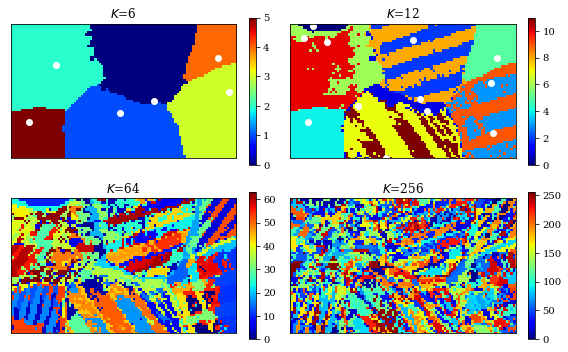

In [27]:
ncols=2
nrows=2 
fig, ax = plt.subplots(nrows, ncols, figsize=(4*ncols, 2.5*nrows))
Ks = [6, 12, 64, 256]
#Ks = [6, 12, 12, 12]

for i in range(nrows):
    for j in range(ncols):
        
        K = Ks[i * ncols + j]
        print("Modeling for {} clusters".format(K))
        
        model = KMeansModel()
        pca = PCA(n_components=32)
        scaler = StandardScaler()
        model.train(features, n_clusters=K, preprocessors=[pca])

        silhouette = model.compute_silhouette_score(features)
        calinski = model.compute_calinski_harabaz_score(features)
        print("Silhouette Score = {}, Calinski-Harabaz Score = {}".format(silhouette, calinski))

        scores = np.array(model.score(features))
        Z = scores.reshape(img_shape)
        
        if ncols == 1 and nrows == 1:
            ax0 = ax
        elif ncols == 1 or nrows == 1:
            ax0 = ax[i * ncols + j]
        else:
            ax0 = ax[i, j]
        img = ax0.imshow(Z[:, :], cmap='jet', aspect=1)
        plt.colorbar(img, ax=ax0, fraction=0.03)
        ax0.set_xlim([0, img_shape[1] - 1])
        ax0.set_ylim([0, img_shape[0] - 1])
        
        if K <= 32:
            delegates = model.delegates(features)
            pts = np.array([idx_to_xy(delegate, img_shape, flip_vertical=False) for delegate in delegates]).astype('int32')
            ax0.scatter(pts[:,0], pts[:,1], color='w', clip_on=False)
#             if i * ncols + j == 1:
#                 ax0.text(45, 50, 'A', color='k', ha=ha, va=va, fontsize=12)
#                 ax0.text(50, 45, 'B', color='k', ha=ha, va=va, fontsize=12)
#                 ax0.text(90, 50, 'C', color='k', ha=ha, va=va, fontsize=12)
#                 ax0.text(10, 30, 'D', color='w', ha=ha, va=va, fontsize=12)
#                 ax0.text(50, 10, 'E', color='w', ha=ha, va=va, fontsize=12)                    
        
        ax0.set_title(r'$K$={}'.format(K), fontsize=12)
        ax0.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax0.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
        
plt.tight_layout()
# fig.savefig("img/BTO_KM_Natural.pdf", bbox_inches='tight', dpi=300)

In [26]:
fig.savefig("img/BTO_KM_Natural_8.pdf", bbox_inches='tight', dpi=300)

Modeling for 6 clusters
Silhouette Score = 0.47592741571952485, Calinski-Harabaz Score = 2758.678155135427
Modeling for 12 clusters
Silhouette Score = 0.20709528466798663, Calinski-Harabaz Score = 1742.363369519263
Modeling for 64 clusters
Silhouette Score = 0.09916505367048703, Calinski-Harabaz Score = 475.052834300819
Modeling for 256 clusters
Silhouette Score = 0.06626450092593314, Calinski-Harabaz Score = 157.33012708915075


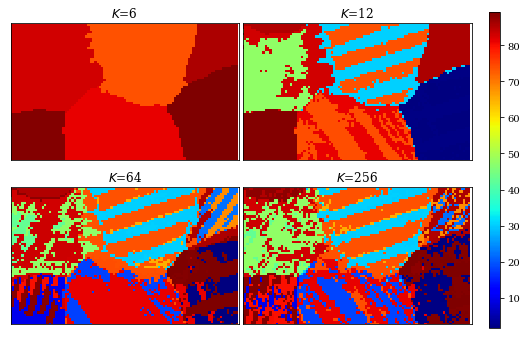

In [171]:
from mpl_toolkits.axes_grid1 import AxesGrid

seq = "BTO_25C_wb3_"
Z = read_seq(seq)
vmax, vmin = Z.max(), Z.min()
seqs = ["BTO_25C_wb3_"]
seqfiles = [os.path.join("seq", seq+".SEQ") for seq in seqs]

feature_file = "BTO_25C_wb3_60_100_256"
img_shape = (60, 100)

features = np.load("features/" + feature_file + ".npy")
features = fill_features(features, img_shape)

ncols=2
nrows=2 
fig, ax = plt.subplots(nrows, ncols, figsize=(4*ncols, 2.5*nrows))

Ks = [6, 12, 64, 256]

for i in range(nrows):
    for j in range(ncols):
        
        K = Ks[i * ncols + j]
        print("Modeling for {} clusters".format(K))
        
        model = KMeansModel()
        pca = PCA(n_components=32)
        scaler = StandardScaler()
        model.train(features, n_clusters=K, preprocessors=[pca])

        silhouette = model.compute_silhouette_score(features)
        calinski = model.compute_calinski_harabaz_score(features)
        print("Silhouette Score = {}, Calinski-Harabaz Score = {}".format(silhouette, calinski))

        scores = np.array(model.score(features))
        Z = model.score_by_seqs(features, seqfiles)
        
        if ncols == 1 and nrows == 1:
            ax0 = ax
        elif ncols == 1 or nrows == 1:
            ax0 = ax[i * ncols + j]
        else:
            ax0 = ax[i, j]            
        # ax0 = ax[i * ncols + j]
        img = ax0.imshow(Z[:, :], cmap='jet', vmin=vmin, vmax=vmax, aspect=1)
        ax0.set_xlim([0, img_shape[1]])
        ax0.set_ylim([0, img_shape[0]])
        
        ax0.set_title(r'$K$={}'.format(K), fontsize=12)
        ax0.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax0.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        

fig.subplots_adjust(bottom=0, top=0.9, left=0, right=0.8, wspace=0.02, hspace=0.02)
cb_ax = fig.add_axes([0.83, 0.02, 0.02, 0.88])
cbar = fig.colorbar(img, cax=cb_ax)

In [91]:
fig.savefig("img/BTO_KM_Indexing.pdf", bbox_inches='tight', dpi=300)

In [138]:
from joblib import Parallel, delayed

seqs = ["BTO_25C_wb3_"]
feature_file = "BTO_25C_wb3_60_100_256"

seqfiles = [os.path.join("seq", seq+".SEQ") for seq in seqs]
labler = SeqLabeler(seqfiles)
Z_seq = labler.Z_map()
mask = np.where(np.isfinite(Z_seq))

img_shape = labler.img_shape()
print("img_shape=", img_shape)
features = np.load("features/" + feature_file + ".npy")
features = fill_features(features, img_shape)

# Ks = [4, 8, 16, 32, 64, 128, 256, 512]
# Ks = [8, 16, 32]
Ks = np.arange(0, 300, 3) + 3
ZIs=[]

def clustering(k):
    print("n_components=", k)

    model = KMeansModel()
    pca = PCA(n_components=32)
    model.train(features, n_clusters=k, preprocessors=[pca])

    silhouette = model.compute_silhouette_score(features)
    calinski = model.compute_calinski_harabaz_score(features)
    print("Silhouette Score = {}, Calinski-Harabaz Score = {}".format(silhouette, calinski))

    Z = model.score_by_seqs(features, seqfiles)
    err = np.mean((Z[mask] - Z_seq[mask])**2)
    print("MSE = ", err)
    return Z, model._estimator.inertia_

with Parallel(n_jobs=-1, verbose=12) as parallel:
    ZIs = parallel(delayed(clustering)(k) for k in Ks)
    Zs = np.array([Z for Z, _ in ZIs])
    Is = np.array([I for _, I in ZIs])

errs = [
    np.mean((Z[mask] - Z_seq[mask])**2)
    for Z in Zs
]

img_shape= (60, 100)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

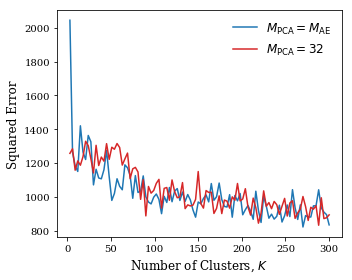

In [168]:
Ks = np.arange(0, 300, 3) + 3
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(Ks, errs1, '-', markerfacecolor='w', markersize=4, label=r'$M_{\rm PCA} = M_{\rm AE}$')
ax.plot(Ks, errs2, '-', color='tab:red', markerfacecolor='w', markersize=4, label=r'$M_{\rm PCA} = 32$')
#ax.plot(Ks, errs1, '-', markerfacecolor='w', markersize=4, label=r'K-Means (all 256 features)')
#ax.plot(Ks, errs2, '-', markerfacecolor='w', markersize=4, label=r'BGM (all 256 features)')
#ax.plot(Ks, errs3, '-', markerfacecolor='w', markersize=4, label=r'K-Means (first 32 principle components)')
# ax.plot(Ks, errs4, '-', markerfacecolor='w', markersize=4, label=r'K-Means (first 8 principle components)')
# plt.ylim([0, 1.05 * np.max(errs2)])
ax.set_xlabel(r'Number of Clusters, $K$', fontsize=12)
ax.set_ylabel(r'Squared Error', fontsize=12)
ax.legend(frameon=False, fontsize=12)

plt.tight_layout()
fig.savefig("img/se.pdf", bbox_inches='tight', dpi=300)

In [163]:
ZIs2 = np.array(ZIs)
np.save("ZIs2.npy", ZIs2)
# np.save("errs1.npy", errs1)
# np.save("errs2.npy", errs2)
# np.save("errs3.npy", errs3)
# np.save("errs4.npy", errs4)
# np.save("Zs1.npy", Zs1)
# np.save("Zs2.npy", Zs2)
# np.save("Zs3.npy", Zs3)
# np.save("Zs4.npy", Zs4)

In [164]:
ZIs1 = np.load("ZIs1.npy")
ZIs2 = np.load("ZIs2.npy")

Is1 = np.array([I for _, I in ZIs1])
Is2 = np.array([I for _, I in ZIs2])

Zs = np.array([Z for Z, _ in ZIs1])
errs1 = [
    np.mean((Z[mask] - Z_seq[mask])**2)
    for Z in Zs
]
Zs = np.array([Z for Z, _ in ZIs2])
errs2 = [
    np.mean((Z[mask] - Z_seq[mask])**2)
    for Z in Zs
]

In [154]:
from joblib import Parallel, delayed

seqs = ["BTO_25C_wb3_"]
feature_file = "BTO_25C_wb3_60_100_256"

seqfiles = [os.path.join("seq", seq+".SEQ") for seq in seqs]
labler = SeqLabeler(seqfiles)
Z_seq = labler.Z_map()
mask = np.where(np.isfinite(Z_seq))

img_shape = labler.img_shape()
print("img_shape=", img_shape)
features = np.load("features/" + feature_file + ".npy")
features = fill_features(features, img_shape)

# Ks = [4, 8, 16, 32, 64, 128, 256, 512]
# Ks = [8, 16, 32]
# Ks = np.arange(0, 300, 3) + 3
Ks = np.arange(2, 21)
SCs=[]

def inertia(k):
    print("K=", k)
    model = KMeansModel()
    pca = PCA(n_components=32)
    model.train(features, n_clusters=k, preprocessors=[pca])
    silhouette = model.compute_silhouette_score(features)
    calinski = model.compute_calinski_harabaz_score(features)
    print("Silhouette Score = {}, Calinski-Harabaz Score = {}".format(silhouette, calinski))
    return silhouette, calinski

with Parallel(n_jobs=-1, verbose=1) as parallel:
    SCs = parallel(delayed(inertia)(k) for k in Ks)
    SCs = np.array(SCs)

img_shape= (60, 100)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  19 | elapsed:   10.8s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   11.3s finished


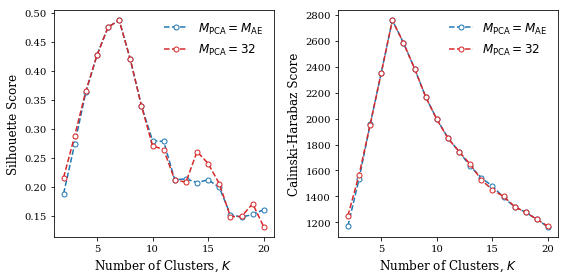

In [156]:
SCs2 = SCs
Ks = np.arange(2, 21)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(Ks, SCs1[:, 0], 'o--', markerfacecolor='w', markersize=5, label=r'$M_{\rm PCA} = M_{\rm AE}$')
ax[0].plot(Ks, SCs2[:, 0], 'o--', color='tab:red', markerfacecolor='w', markersize=5, label=r'$M_{\rm PCA} = 32$')
ax[0].set_xlabel(r'Number of Clusters, $K$', fontsize=12)
ax[0].set_ylabel(r'Silhouette Score', fontsize=12)
#ax[0].set_ylim([0.1, 0.6])
ax[0].legend(loc='upper right', frameon=False, fontsize=12)

ax[1].plot(Ks, SCs1[:, 1], 'o--', markerfacecolor='w', markersize=5, label=r'$M_{\rm PCA} = M_{\rm AE}$')
ax[1].plot(Ks, SCs2[:, 1], 'o--', color='tab:red', markerfacecolor='w', markersize=5, label=r'$M_{\rm PCA} = 32$')
ax[1].set_xlabel(r'Number of Clusters, $K$', fontsize=12)
ax[1].set_ylabel(r'Calinski-Harabaz Score', fontsize=12)
#ax[1].set_ylim([1100, 3200])
ax[1].legend(loc='upper right', frameon=False, fontsize=12)

plt.tight_layout()
fig.savefig("img/SCH.pdf", dpi=300)

In [199]:
import time

from joblib import Parallel, delayed

from itertools import combinations, islice
from scipy.stats import kendalltau, spearmanr, pearsonr
from scipy.special import comb

def chunks(length, chunksize):
    i = 0
    while True:
        c = list(islice(combinations(range(length), 2), chunksize * i, chunksize * (i+1)))
        if len(c) > 0:
            i += 1
            yield c
        else:
            return

def euclidean(p):    
    d = p[:, 0, ...] - p[:, 1, ...]
    if len(d.shape) > 1:
        return np.linalg.norm(d, axis=-1)
    else:
        return d
    
def topo_disorder(a, b, dist=euclidean):
    if len(a) != len(b):
        raise ValueError("a and b must be of the same length")
    if not isinstance(a, np.ndarray):
        a = np.array(a)
    if not isinstance(b, np.ndarray):
        b = np.array(b)
    if len(a) > 10000:
        print("Truncate both data set to 1000")
        choice = np.random.choice(np.arange(len(a)), 1000)
        a = a[choice]
        b = b[choice]
    t0 = time.time()
    with Parallel(n_jobs=-1, verbose=1) as parallel:
        d1 = parallel(delayed(dist)(a[np.array(c)]) for c in chunks(len(a), 10000))
        d2 = parallel(delayed(dist)(b[np.array(c)]) for c in chunks(len(b), 10000))
    d1 = np.hstack(d1)
    d2 = np.hstack(d2)
    srt = np.argsort(d2)
    d1 = d1[srt]
    d2 = d2[srt]    
    print(d1, d2)
    # print("Spend {} sec to compute {} pairwise distances".format(time.time() - t0, len(d1)))
    t0 = time.time()
#     r, p = spearmanr(d1, d2)
#     print(r, p)
#     return r
    t, p =  kendalltau(d1, d2)
    print(t, p)
    return t
    # print("Spend {} sec to compute Kendall tau for {} data points".format(time.time() - t0, len(d1)))
    # return (1 - t) / 2
    
topo_disorder([1, 2, 3, 4], [1, 2, 3, 4])
# topo_disorder(features, features)

[-3 -2 -2 -1 -1 -1] [-3 -2 -2 -1 -1 -1]
1.0 0.014145444224306181


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


1.0

Silhouette Score = 0.06571227011568427, Calinski-Harabaz Score = 157.33936104573783


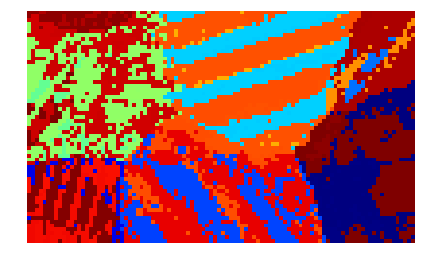

In [114]:
seq = "BTO_25C_wb3_"
Z = read_seq(seq)
vmax, vmin = Z.max(), Z.min()
seqs = ["BTO_25C_wb3_"]
seqfiles = [os.path.join("seq", seq+".SEQ") for seq in seqs]

seqfiles = [os.path.join("seq", seq+".SEQ") for seq in seqs]
labler = SeqLabeler(seqfiles)
Z_seq = labler.Z_map()
mask = np.where(np.isfinite(Z_seq))

model = KMeansModel()
pca = PCA(n_components=32)
scaler = StandardScaler()
model.train(features, n_clusters=256, preprocessors=[pca])

silhouette = model.compute_silhouette_score(features)
calinski = model.compute_calinski_harabaz_score(features)
print("Silhouette Score = {}, Calinski-Harabaz Score = {}".format(silhouette, calinski))

scores = np.array(model.score(features))
# Z = model.color_by_pca(scores.reshape(img_shape), scaling='samples')
Z = model.score_by_seqs(features, seqfiles)

fig, ax = plt.subplots(ncols=1, nrows=1)
ax.imshow(Z[::-1, :], cmap='jet', aspect=1)
ax.axis('off')
plt.tight_layout()

In [200]:
Z_flat = Z_seq.flatten()
Z1_flat = Z.flatten()
mask = np.where(np.isfinite(Z_flat))
Z_flat = Z_flat[mask]
features = features[mask]
_, bins = np.histogram(Z_flat, 100)
nf = np.linalg.norm(features, axis=1)

def topo_dist(a, b):
    c = b / a
    return c.min(), c.max()

# print(topo_dist(nf, np.digitize(Z_flat, bins)))
topo_disorder(pca.transform(features), np.digitize(Z_flat, bins))
#topo_disorder(Z1_flat[mask], Z_flat[mask])
#spearmanr(nf, Z_flat)
kendalltau(nf, Z_flat)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 302 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 902 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1352 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  4.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  3.5min finished


[18.67624388 17.50017997 23.30576872 ... 17.57422681 17.75828041
 17.04116067] [-100 -100 -100 ...  100  100  100]
0.013047283180463616 0.0


KendalltauResult(correlation=0.09542662964132152, pvalue=1.4948232710856059e-28)

In [163]:
topo_disorder([1, 2, 3, 4], [2, 3, 4, 6])

Spend 0.009972333908081055 sec to compute 6 pairwise distances
Spend 0.0 sec to compute Kendall tau for 6 data points


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished


0.08187899499645462

In [206]:
from joblib import Parallel, delayed

seqs = ["BTO_25C_wb3_"]
feature_file = "BTO_25C_wb3_60_100_256"

seqfiles = [os.path.join("seq", seq+".SEQ") for seq in seqs]
labler = SeqLabeler(seqfiles)
Z_seq = labler.Z_map()
mask = np.where(np.isfinite(Z_seq))

img_shape = labler.img_shape()
print("img_shape=", img_shape)
features = np.load("features/" + feature_file + ".npy")
features = fill_features(features, img_shape)

# Ks = [4, 8, 16, 32, 64, 128, 256, 512]
#Ks = [8, 16, 32]
Ks = np.arange(0, 300, 3) + 3
results=[]

def clustering(k):
    print("n_components=", k)

    model = KMeansModel()
    pca = PCA(n_components=32)
    model.train(features, n_clusters=k, preprocessors=[])

    silhouette = model.compute_silhouette_score(features)
    calinski = model.compute_calinski_harabaz_score(features)
    print("Silhouette Score = {}, Calinski-Harabaz Score = {}".format(silhouette, calinski))

    Z = model.score_by_seqs(features, seqfiles)
    return Z, model._estimator.inertia_

with Parallel(n_jobs=-1, verbose=1) as parallel:
    results = parallel(delayed(clustering)(k) for k in Ks)
    Zs = np.array([Z for Z, _ in results])
    Is = np.array([I for _, I in results])

img_shape= (60, 100)


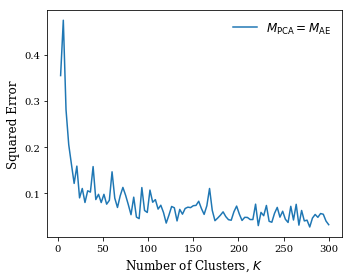

In [130]:
Ks = np.arange(0, 300, 3) + 3
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.plot(Ks, kss, '-', markerfacecolor='w', markersize=4, label=r'$M_{\rm PCA} = M_{\rm AE}$')
ax.set_xlabel(r'Number of Clusters, $K$', fontsize=12)
ax.set_ylabel(r'Squared Error', fontsize=12)
ax.legend(frameon=False, fontsize=12)

plt.tight_layout()
# fig.savefig("img/se.pdf", bbox_inches='tight', dpi=300)

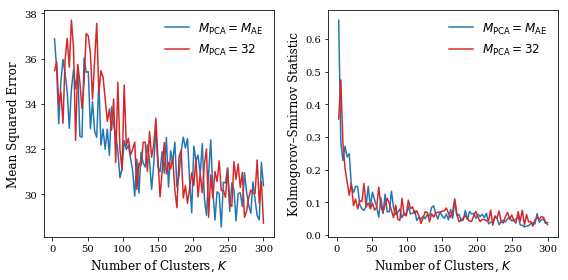

In [210]:
Ks = np.arange(0, 300, 3) + 3
mses1, ks1 = extract_mse_ks(results1)
mses2, ks2 = extract_mse_ks(results2)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(Ks, mses1, '-', markerfacecolor='w', markersize=4, label=r'$M_{\rm PCA} = M_{\rm AE}$')
ax[0].plot(Ks, mses2, '-', color='tab:red', markerfacecolor='w', markersize=4, label=r'$M_{\rm PCA} = 32$')
ax[0].set_xlabel(r'Number of Clusters, $K$', fontsize=12)
ax[0].set_ylabel(r'Mean Squared Error', fontsize=12)
#ax[0].set_ylim([0, None])
ax[0].legend(frameon=False, fontsize=12)

ax[1].plot(Ks, ks1, '-', markerfacecolor='w', markersize=4, label=r'$M_{\rm PCA} = M_{\rm AE}$')
ax[1].plot(Ks, ks2, '-', color='tab:red', markerfacecolor='w', markersize=4, label=r'$M_{\rm PCA} = 32$')
ax[1].set_xlabel(r'Number of Clusters, $K$', fontsize=12)
ax[1].set_ylabel(r'Kolmogorov–Smirnov Statistic', fontsize=12)
#ax[1].set_ylim([0, None])
ax[1].legend(frameon=False, fontsize=12)

plt.tight_layout()
fig.savefig("img/se.pdf", bbox_inches='tight', dpi=300)

In [135]:
results1 = results

In [204]:
def extract_mse_ks(results):
    Zs = np.array([Z for Z, _ in results])
    mses = [
        np.sqrt(np.mean((Z[mask] - Z_seq[mask])**2))
        for Z in Zs
    ]
    kss = [
        ks_2samp(Z[mask].flatten(), Z_seq[mask].flatten())[0]
        for Z in Zs
    ]
    return mses, kss

